## Кожин Асан
## telegram: @tioplon

## В качестве решонной задачи использую facades, архитектура cyclegan

До этого не работал с keras поэтому очень много кода писал смотря на другие источники.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.experimental.AUTOTUNE

https://www.tensorflow.org/tutorials/generative/pix2pix
Использовал этот ресурс для кода загрузки даных.

In [ ]:
URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz', origin=URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')

30171136/30168306 [==============================] - 7s 0us/step


In [ ]:
BATCH_SIZE = 1 #Как в статье
IMG_HEIGHT, IMG_WIDTH = 256, 256

In [ ]:
def load(img_path):
  image = tf.io.read_file(img_path)
  image = tf.image.decode_jpeg(image)
  image = tf.cast(image, tf.float32)

  w = tf.shape(image)[1]

  w = w // 2
  real_img = image[:, :w, :]
  label_img = image[:, w:, :]

  return real_img, label_img

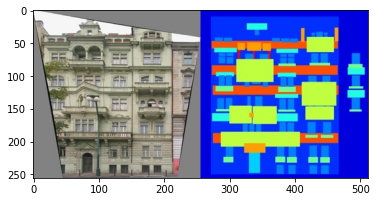

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(PATH+'train/100.jpg')
plt.imshow(img)

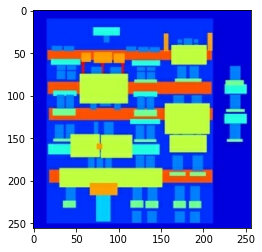

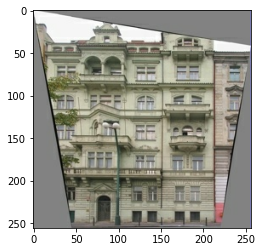

In [ ]:
real_img, label_img = load(PATH+'train/100.jpg')
plt.figure()
plt.imshow(label_img/255.0)
plt.figure()
plt.imshow(real_img/255.0)

In [ ]:
def resize(real_img, label_img, height=256, width=256):
  real_img = tf.image.resize(real_img, [height, width],
                             method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  label_img = tf.image.resize(label_img, [height, width],
                             method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return real_img, label_img

In [ ]:
@tf.function()
def preprocess(real_img, label_img):
  real_img, label_img = resize(real_img, label_img, height=286, width=286)
  stacked = tf.stack([real_img, label_img], axis=0)
  cropped_image = tf.image.random_crop(stacked, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  cropped_image = (cropped_image / 127.5) - 1
  real_img, label_img = cropped_image[0], cropped_image[1]

  if tf.random.uniform(()) > 0.5:
    real_img = tf.image.flip_left_right(real_img)
    label_img = tf.image.flip_left_right(label_img)

  return real_img, label_img

In [ ]:
def load_image_train(image_file):
  real_img, label_img = load(image_file)
  return preprocess(real_img, label_img)


def load_image_test(image_file):
  real_img, label_img = load(image_file)
  real_img, label_img = resize(real_img, label_img)
  real_img = (real_img / 127.5) - 1
  label_img = (label_img / 127.5) - 1
  return real_img, label_img

In [ ]:
train_dataset = tf.data.Dataset.list_files(PATH+'train/*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=autotune)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(PATH+'test/*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

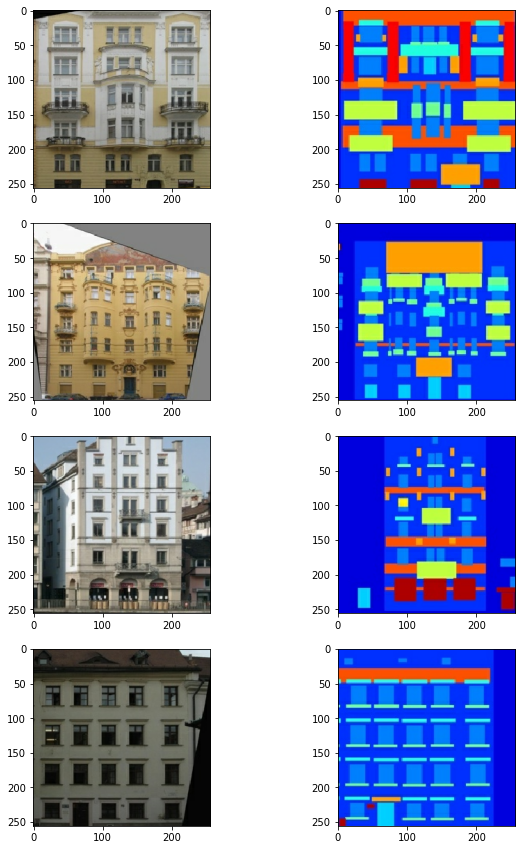

In [ ]:
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(train_dataset.take(4)):
    horse = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    zebra = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
plt.show()


In [ ]:
#Код с https://keras.io/examples/generative/cyclegan/

kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.
    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.
    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


Основа для моего кода https://keras.io/examples/generative/cyclegan/

Так же сверял архитектуру генераторов и дискриминаторов с оригинальной статьи.

In [ ]:
class CycleGAN(keras.Model):
  def __init__(self):
    super(CycleGAN, self).__init__()

    def generator_loss_fn(fake, loss_fn=keras.losses.MeanSquaredError()):
      fake_loss = loss_fn(tf.ones_like(fake), fake)
      return fake_loss

    def discriminator_loss_fn(real, fake, loss_fn=keras.losses.MeanSquaredError()):
      real_loss = loss_fn(tf.ones_like(real), real)
      fake_loss = loss_fn(tf.zeros_like(fake), fake)
      return 0.5 * (real_loss + fake_loss)

    self.input_img_size = (256, 256, 3)

    self.g_AB = self.get_generator(name="generator_AB")
    self.g_BA = self.get_generator(name="generator_BA")

    self.disc_A = self.get_discriminator(name="discriminator_A")
    self.disc_B = self.get_discriminator(name="discriminator_B")

    self.gen_loss_fn = generator_loss_fn
    self.disc_loss_fn = discriminator_loss_fn
    self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
    self.identity_loss_fn = keras.losses.MeanAbsoluteError()

  def compile(self):
    super(CycleGAN, self).compile()
    linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
        2e-4,
        40,
        end_learning_rate=0,
        power=1.0,
        cycle=False,
        name=None,
    )
    #Used learning rate of 2e-4 for first 100 epochs
    self.g_AB_opt = keras.optimizers.Adam(learning_rate=linear_decay, beta_1=0.5)
    self.g_BA_opt = keras.optimizers.Adam(learning_rate=linear_decay, beta_1=0.5)
    self.disc_A_opt = keras.optimizers.Adam(learning_rate=linear_decay, beta_1=0.5)
    self.disc_B_opt = keras.optimizers.Adam(learning_rate=linear_decay, beta_1=0.5)

  def train_step(self, batch_data):
    #a is photos b is maps
    real_a, real_b = batch_data

    with tf.GradientTape(persistent=True) as tape:

      fake_b = self.g_AB(real_a, training=True)
      fake_a = self.g_BA(real_b, training=True)

      #ideally should be cycled to real
      cycled_a = self.g_BA(fake_b, training=True)
      cycled_b = self.g_AB(fake_a, training=True)

      same_a = self.g_BA(real_a, training=True)
      same_b = self.g_AB(real_b, training=True)

      disc_real_a = self.disc_A(real_a, training=True)
      disc_fake_a = self.disc_A(fake_a, training=True)

      disc_real_b = self.disc_B(real_b, training=True)
      disc_fake_b = self.disc_B(fake_b, training=True)

      gen_AB_loss = self.gen_loss_fn(disc_fake_b)
      gen_BA_loss = self.gen_loss_fn(disc_fake_a)

      # Cycle loss for generators
      cycle_loss_AB = self.cycle_loss_fn(real_b, cycled_b) * 10.0
      cycle_loss_BA = self.cycle_loss_fn(real_a, cycled_a) * 10.0

      id_loss_AB = self.identity_loss_fn(real_b, same_b) * 10.0 * 0.5
      id_loss_BA = self.identity_loss_fn(real_a, same_a) * 10.0 * 0.5

      #generator total loss
      total_loss_AB = gen_AB_loss + cycle_loss_AB + id_loss_AB
      total_loss_BA = gen_BA_loss + cycle_loss_BA + id_loss_BA

      #Discriminators losses
      disc_A_loss = self.disc_loss_fn(disc_real_a, disc_fake_a)
      disc_B_loss = self.disc_loss_fn(disc_real_b, disc_fake_b)

    grads_AB = tape.gradient(total_loss_AB, self.g_AB.trainable_variables)
    grads_BA = tape.gradient(total_loss_BA, self.g_BA.trainable_variables)

    grads_disc_A = tape.gradient(disc_A_loss, self.disc_A.trainable_variables)
    grads_disc_B = tape.gradient(disc_B_loss, self.disc_B.trainable_variables)

    self.g_AB_opt.apply_gradients(zip(grads_AB, self.g_AB.trainable_variables))
    self.g_BA_opt.apply_gradients(zip(grads_BA, self.g_BA.trainable_variables))

    self.disc_A_opt.apply_gradients(zip(grads_disc_A, self.disc_A.trainable_variables))
    self.disc_B_opt.apply_gradients(zip(grads_disc_B, self.disc_B.trainable_variables))

    return {"AB_loss": total_loss_AB,
            "BA_loss": total_loss_BA,
            "Disc_A_loss": disc_A_loss,
            "Disc_B_loss": disc_B_loss}

  def get_generator(self,
                    filters=64,
                    num_downsampling_blocks=2,
                    num_residual_blocks=9,
                    num_upsample_blocks=2,
                    gamma_initializer=gamma_init,
                    name=None):
    input = layers.Input(shape=self.input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    #Downsampling
    x = downsample(x, filters=filters*2, activation=layers.Activation("relu"))
    x = downsample(x, filters=filters*4, activation=layers.Activation("relu"))

    for _ in range(num_residual_blocks):
      x = residual_block(x, activation=layers.Activation("relu"))

    x = upsample(x, filters=filters*4, activation=layers.Activation("relu"))
    x = upsample(x, filters=filters*2, activation=layers.Activation("relu"))

    x = ReflectionPadding2D(padding=(3,3))(x)
    out = layers.Activation("tanh")(layers.Conv2D(3, (7, 7), padding="valid")(x))

    return keras.models.Model(inputs=input, outputs=out, name=name)


  def get_discriminator(self, filters=64, kernel_initializer=kernel_init,
                        num_downsampling=3, name=None):
    #https://arxiv.org/pdf/1611.07004.pdf  - страница 16
    #                             C64-C128-C256-C512
    input = layers.Input(shape=self.input_img_size, name=name + "_img_input")
    x = layers.Conv2D(filters, (3, 3), strides=(1, 1), padding='same',
                      kernel_initializer=kernel_initializer)(input)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = downsample(x, filters=filters*2, activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4), strides=(2, 2))
    x = downsample(x, filters=filters*4, activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4), strides=(2, 2))
    x = downsample(x, filters=filters*8, activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4), strides=(1, 1))
    out = layers.Conv2D(1, (4, 4), strides=(1, 1), padding='same',
                        kernel_initializer=kernel_initializer)(x)
    
    return keras.models.Model(inputs=input, outputs=out, name=name)

In [ ]:
class ImageCallback(keras.callbacks.Callback):
  def __init__(self, num_img=4):
    self.num_img = num_img

  def on_epoch_end(self, epoch, logs=None):
    _, ax = plt.subplots(2, 4, figsize=(8, 8))
    for i, samples in enumerate(test_dataset.take(2)):
      label, real  = samples[1], samples[0]
      gen_label = cyclegan_model.g_AB(real)
      gen_real = cyclegan_model.g_BA(label)
      label = (((label[0] * 127.5) + 127.5).numpy()).astype(np.uint8)
      gen_label = (((gen_label[0] * 127.5) + 127.5).numpy()).astype(np.uint8)
      real = (((real[0] * 127.5) + 127.5).numpy()).astype(np.uint8)
      gen_real = (((gen_real[0] * 127.5) + 127.5).numpy()).astype(np.uint8)
      ax[i, 0].imshow(real)
      ax[i, 0].axis("off")
      ax[i, 1].imshow(gen_real)
      ax[i, 1].axis("off")
      ax[i, 2].imshow(label)
      ax[i, 2].axis("off")
      ax[i, 3].imshow(gen_label)
      ax[i, 3].axis("off")
    plt.show()

In [ ]:
cyclegan_model = CycleGAN()

plotter = ImageCallback()

checkpoints = "/content/model_checkpoints/cyclegan_checkpoints100.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoints)

cyclegan_model.compile()

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
weight_file = "/content/model_checkpoints/cyclegan_checkpoints60.040"
cyclegan_model.load_weights(weight_file).expect_partial()
print("Weights loaded successfully")

Weights loaded successfully


### Train history

Обучал в несколько подходов на Google Colab

1. 40 epoch lr=2e-4
2. 20 epoch lr=2e-4
3. 40 epoch lr=2e-4
4. 40 epoch with Linear Decay from 2e-4 to 0

In [ ]:
cyclegan_model.fit(
    train_dataset,
    epochs=40,
    callbacks=[model_checkpoint_callback, plotter],
    )

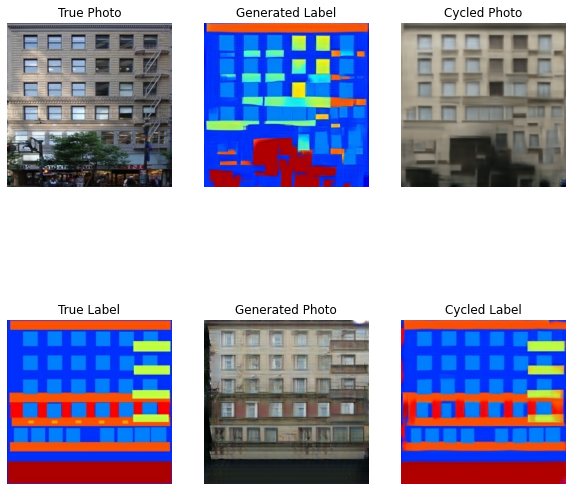

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
samples = next(iter(test_dataset.take(1)))

label, real  = samples[1], samples[0]
gen_label = cyclegan_model.g_AB(real)
gen_real = cyclegan_model.g_BA(label)
cycle_real = cyclegan_model.g_BA(gen_label)
cycle_label = cyclegan_model.g_AB(gen_real)
label = (((label[0] * 127.5) + 127.5).numpy()).astype(np.uint8)
gen_label = (((gen_label[0] * 127.5) + 127.5).numpy()).astype(np.uint8)
real = (((real[0] * 127.5) + 127.5).numpy()).astype(np.uint8)
gen_real = (((gen_real[0] * 127.5) + 127.5).numpy()).astype(np.uint8)
cycle_label = (((cycle_label[0] * 127.5) + 127.5).numpy()).astype(np.uint8)
cycle_real = (((cycle_real[0] * 127.5) + 127.5).numpy()).astype(np.uint8)

ax[0, 0].imshow(real)
ax[0, 1].imshow(gen_label)
ax[0, 2].imshow(cycle_real)
ax[0, 0].set_title("True Photo")
ax[0, 1].set_title("Generated Label")
ax[0, 2].set_title("Cycled Photo")

ax[1, 0].imshow(label)
ax[1, 1].imshow(gen_real)
ax[1, 2].imshow(cycle_label)
ax[1, 0].set_title("True Label")
ax[1, 1].set_title("Generated Photo")
ax[1, 2].set_title("Cycled Label")

for a in ax.flat:
  a.axis("off")
plt.show()

Думаю результаты получились неплохими. И я считаю что повторил архиетктуру хоть и решил на бесполезной ей задаче.

Генератор семантической карты использует темно красный цвет не по назначению и обозначает им обьекты не связанные со зданием или черные полосы вокруг изображения.

### Custom Image drawn by me

Тут я захотел проверить что сгенерирует нейронная сеть на здание нарисованное мной. Получилось плохо. возмножно я использую labels неправильно.

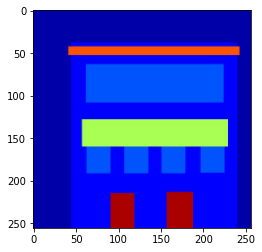

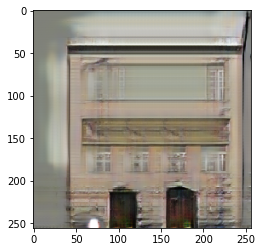

In [ ]:
image = tf.io.read_file("/content/Drawing.sketchpad.jpeg")
image = tf.image.decode_jpeg(image)
image = tf.cast(image, tf.float32)
real_img, label_img = resize(image, image)
label_img = (label_img / 127.5) - 1
generated = cyclegan_model.g_BA(tf.expand_dims(label_img, axis=0))
generated = (((generated[0] * 127.5) + 127.5).numpy()).astype(np.uint8)
label_img = (((label_img * 127.5) + 127.5).numpy()).astype(np.uint8)

plt.figure()
plt.imshow(label_img)
plt.figure()
plt.imshow(generated)
plt.show()